In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import tensorflow as tf
import numpy as np
import imageio
import json
import random
import time

from run_nerf_helpers import *
import nerf_renderer as nr
from misc_helpers import *
from load_llff import load_llff_data

In [2]:
def pose_to_rays(H, W, focal, c2w, near=0., far=1., ndc=False):
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    viewdirs = rays_d
    viewdirs = viewdirs / tf.linalg.norm(viewdirs, axis=-1, keepdims=True)
    viewdirs = tf.cast(tf.reshape(viewdirs, [-1, 3]), dtype=tf.float32)

    sh = rays_d.shape  # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, focal, tf.cast(1., tf.float32), rays_o, rays_d)

    # Create ray batch
    rays_o = tf.cast(tf.reshape(rays_o, [-1, 3]), dtype=tf.float32)
    rays_d = tf.cast(tf.reshape(rays_d, [-1, 3]), dtype=tf.float32)
    near, far = near * \
        tf.ones_like(rays_d[..., :1]), far * tf.ones_like(rays_d[..., :1])

    # (ray origin, ray direction, min dist, max dist) for each ray
    rays = tf.concat([rays_o, rays_d, near, far], axis=-1)
    rays = tf.concat([rays, viewdirs], axis=-1)
    return rays

In [3]:
def nerf_raw2weights(raw, z_vals, rays_d):  
    def raw2alpha(raw, dists, act_fn=tf.nn.relu): return 1.0 - \
        tf.exp(-act_fn(raw) * dists)

    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = tf.concat(
        [dists, tf.broadcast_to([1e10], dists[..., :1].shape)],
        axis=-1)  # [N_rays, N_samples]

    dists = dists * tf.linalg.norm(rays_d[..., None, :], axis=-1)

    rgb = tf.math.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]

    noise = 0.
    # if raw_noise_std > 0.:
    #     noise = tf.random.normal(raw[..., 3].shape) * raw_noise_std

    alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]

    mu_expected = tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * mu_expected 

    return weights

In [4]:
def nerf_raw2outputs2(raw, z_vals, rays_d):   
    def raw2alpha(raw, dists, act_fn=tf.nn.relu): return 1.0 - \
        tf.exp(-act_fn(raw) * dists)

    dists = z_vals[..., 1:] - z_vals[..., :-1]

    dists = tf.concat(
        [dists, tf.broadcast_to([1e10], dists[..., :1].shape)],
        axis=-1)  # [N_rays, N_samples]

    dists = dists * tf.linalg.norm(rays_d[..., None, :], axis=-1)
    rgb = tf.math.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]
    noise = 0.
    # if raw_noise_std > 0.:
    #     noise = tf.random.normal(raw[..., 3].shape) * raw_noise_std

    alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]
    mu_expected = tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True) 
    
    return rgb, alpha, mu_expected

In [5]:
def run_mu_model(pts, viewdirs, model_mu, embed_fn, embeddirs_fn):
    pts_flat = tf.reshape(pts, [-1, pts.shape[-1]])
    embedded = embed_fn(pts_flat)
    
    input_dirs = tf.broadcast_to(viewdirs[:, None], pts.shape)
    input_dirs_flat = tf.reshape(input_dirs, [-1, input_dirs.shape[-1]])
    embedded_dirs = embeddirs_fn(input_dirs_flat)
    embedded = tf.concat([embedded, embedded_dirs], -1)

    outputs_flat = model_mu(embedded)
    mu_out = tf.reshape(outputs_flat, list(
        pts.shape[:-1]) + [outputs_flat.shape[-1]])
    return mu_out

In [6]:
def process_ray_batch(ray_batch,
                      models,
                      N_samples,
                      retraw=False,
                      lindisp=False,
                      perturb=0.,
                      N_importance=0,
                      white_bkgd=False,
                      raw_noise_std=0.,
                      verbose=False):

    assert('model' in models and 'model_fine' in models and 'model_mu' in models and N_importance > 0)

    N_rays = ray_batch.shape[0]

    # Extract ray origin, direction.
    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]  # [N_rays, 3] each

    # Extract unit-normalized viewing direction.
    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None

    # Extract lower, upper bound for ray distance.
    bounds = tf.reshape(ray_batch[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1]  # [-1,1]

    # Decide where to sample along each ray. Under the logic, all rays will be sampled at
    # the same times.
    t_vals = tf.linspace(0., 1., N_samples)
    if not lindisp:
        # Space integration times linearly between 'near' and 'far'. Same
        # integration points will be used for all rays.
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        # Sample linearly in inverse depth (disparity).
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))
    z_vals = tf.broadcast_to(z_vals, [N_rays, N_samples])

    # Perturb sampling time along each ray.
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = tf.concat([mids, z_vals[..., -1:]], -1)
        lower = tf.concat([z_vals[..., :1], mids], -1)
        # stratified samples in those intervals
        t_rand = tf.random.uniform(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand

    # Points in space to evaluate model at.
    pts = rays_o[..., None, :] + rays_d[..., None, :] * \
        z_vals[..., :, None]  # [N_rays, N_samples, 3]
    pts_0 = pts

    # Evaluate model at each point.
    model_coarse, c_embed_fn, c_embeddir_fn = models['model']
    raw = nr.run_network(pts, viewdirs, model_coarse, c_embed_fn, c_embeddir_fn)  # [N_rays, N_samples, 4]
    weights = nerf_raw2weights(raw, z_vals, rays_d)    
    # print(weights.shape)

    # Obtain additional integration times to evaluate based on the weights
    # assigned to colors in the coarse model.
    z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
    z_samples = sample_pdf(
        z_vals_mid, weights[..., 1:-1], N_importance, det=(perturb == 0.))
    z_samples = tf.stop_gradient(z_samples)

    # Obtain all points to evaluate color, density at.
    z_vals = tf.sort(tf.concat([z_vals, z_samples], -1), -1)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * \
        z_vals[..., :, None]  # [N_rays, N_samples + N_importance, 3]

    # Make predictions with network_fine.
    model_fine, f_embed_fn, f_embeddir_fn = models['model_fine']
    raw = nr.run_network(pts, viewdirs, model_fine, f_embed_fn, f_embeddir_fn)
    rgb, alpha, mu_expected = nerf_raw2outputs2(raw, z_vals, rays_d)
    # print(rgb.shape, alpha.shape, mu_expected.shape)

    model_mu, mu_embed_fn, mu_embeddirs_fn = models['model_mu']
    mu_out = run_mu_model(pts, viewdirs, model_mu, mu_embed_fn, mu_embeddirs_fn)
    mu_out = tf.reshape(mu_out, shape = mu_expected.shape)
    mu_out = tf.math.tanh(tf.nn.relu(mu_out))

    # ridx = random.randint(0, mu_expected.shape[0] -1)
    # print('mu expected: ')
    # print(np.round(mu_expected[ridx], 3))
    # print('mu found: ')
    # print(np.round(mu_out[ridx], 3))

    weights = alpha * mu_out                 
    return tf.reduce_sum(weights[..., None] * rgb, axis=-2)  # [N_rays, 3]    


In [7]:
def get_rgb_test(render_data, models, chunk_size = 1024*32, **kwargs):    
    H, W, focal, c2w, near, far = render_data
    ray_data = pose_to_rays(H, W, focal, c2w, near, far, ndc = False)
    print(ray_data.shape)
    
    rgb_composite = []
    for i in range(0, ray_data.shape[0], chunk_size):        
        ray_batch = ray_data[i : i+chunk_size]
        rgb = process_ray_batch(ray_batch, models, **kwargs)
        rgb_composite.append(rgb)
    
    final_rgb = tf.concat(rgb_composite, axis = 0)
    print(final_rgb.shape)
    final_rgb = tf.reshape(final_rgb, (H, W, 3))

    return final_rgb

In [8]:
def load_models(args):
    models = {}

    embed_fn, input_ch = get_embedder(args.multires, args.i_embed)
    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(
            args.multires_views, args.i_embed)
    output_ch = 4
    skips = [4]

    model = init_nerf_model(
        D=args.netdepth, W=args.netwidth,
        input_ch=input_ch, output_ch=output_ch, skips=skips,
        input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)
    models = {'model': [model, embed_fn, embeddirs_fn]}   
    
    model_fine = init_nerf_model(
        D=args.netdepth_fine, W=args.netwidth_fine,
        input_ch=input_ch, output_ch=output_ch, skips=skips,
        input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)
    models['model_fine'] = [model_fine, embed_fn, embeddirs_fn]

    model_mu = init_mu_model(
            D=args.netdepth_fine, W=args.netwidth_fine,
            input_ch=input_ch, output_ch=output_ch, skips=skips,
            input_ch_views=input_ch_views)
    models['model_mu'] = [model_mu, embed_fn, embeddirs_fn]
    
    return models

In [9]:
def load_data(args):
    images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor,
                                                                  recenter=True, bd_factor=.75,
                                                                  spherify=args.spherify)
    hwf = poses[0, :3, -1]
    H, W, focal = hwf
    H, W = int(H), int(W)

    poses = poses[:, :3, :4]
    print('Loaded llff', images.shape,
            render_poses.shape, hwf, args.datadir)

    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = tf.reduce_min(bds) * .9
        far = tf.reduce_max(bds) * 1.
    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far)   

    return images, poses, H, W, focal, near, far

In [10]:
args_file = './data/rubiks/cropped/logs/rubiks/args.txt'
args = ConfigReader(args_file)

render_kwargs = {
    'perturb': args.perturb,
    'N_importance': args.N_importance,
    'N_samples': args.N_samples,
    'white_bkgd': args.white_bkgd,
    'raw_noise_std': args.raw_noise_std,
    }

print(args.factor)

4


In [11]:
models = load_models(args)

model_coarse_weights_file = 'data/rubiks/cropped/logs/rubiks/model_150000.npy'
model_fine_weights_file = 'data/rubiks/cropped/logs/rubiks/model_fine_150000.npy'
model_mu_weights_file = 'data/rubiks/cropped/logs/rubiks_mu/model_mu_170000.npy'

models['model'][0].set_weights(np.load(model_coarse_weights_file, allow_pickle=True))
models['model_fine'][0].set_weights(np.load(model_fine_weights_file, allow_pickle=True))
models['model_mu'][0].set_weights(np.load(model_mu_weights_file, allow_pickle=True))

MODEL_NERF 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL_NERF 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL_MU 63 27 <class 'int'> <class 'int'>
(None, 90) (None, 63) (None, 27)


In [12]:
images, poses, H, W, focal, near, far = load_data(args)

# bds_dict = {
#         'near': tf.cast(near, tf.float32),
#         'far': tf.cast(far, tf.float32),
# }
# render_kwargs.update(bds_dict)

Loaded image data (250, 250, 3, 132) [250.        250.        549.4387929]
Loaded ./data/rubiks/cropped/ 2.2962166918186226 11.288918670814095
Data:
(132, 3, 5) (132, 250, 250, 3) (132, 2)
HOLDOUT view is 128
Loaded llff (132, 250, 250, 3) (120, 3, 5) [250.     250.     549.4388] ./data/rubiks/cropped/
DEFINING BOUNDS
NEAR FAR tf.Tensor(0.46544135, shape=(), dtype=float32) tf.Tensor(2.5425055, shape=(), dtype=float32)


39
(62500, 11)
(62500, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


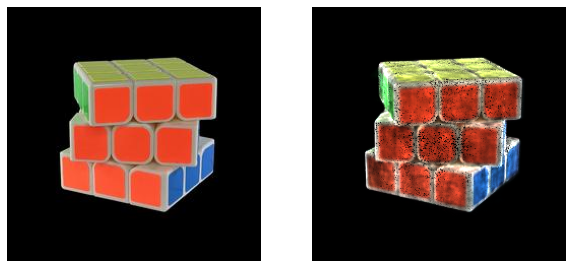

In [13]:
ri = random.randint(0, images.shape[0] - 1)
print(ri)

render_data = [H, W, focal, poses[ri], near, far]
rendered = get_rgb_test(render_data, models, chunk_size = 1024*8, **render_kwargs)

plot_images([images[ri], rendered], 1, 2)